In [5]:
from sideinfo_release import *
import matplotlib.pyplot as plt
import numpy as np
import timeit
import sys
import argparse


then = timeit.default_timer()

parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, default = '',  help='data path')
parser.add_argument('--dim', type=int, default = 1,  help='dimension of data')
parser.add_argument('--init', type=int, default = 5,  help='number of inits')
parser.add_argument('--out', type=str, default = 'test',  help='output_directory')
parser.add_argument('--prefix', type=str, default = 'http://localhost:8888/files',  help='url prefix')
parser.add_argument('--alpha', type=float, default = 0.05,  help='fdr')
parser.add_argument('--fdr_scale', type=float, default = 1,  help='fd scale')
parser.add_argument('--mirror', type=float, default = 1,  help='mirror')
parser.add_argument('--usedim', type=int, default = -1,  help='dimension of data')







opt = parser.parse_args(['--data', 'data/gtex_filtered3.csv', '--init', '1', '--alpha', '0.1', '--fdr_scale', '1',  '--dim',  '2'   ])
print (opt)

fn = opt.data
dim = opt.dim




data = np.loadtxt(open(fn, "rb"), delimiter=",", skiprows=1)
x = data[:,0:dim]
p = data[:,dim]
h = data[:,dim+1]
n_samples = len(x)


if opt.usedim >= 0:
    x = x[:, opt.usedim]
    dim = 1
    
grids = None
x_prob = None

if dim == 1:
    max_x = np.max(x)
    min_x = np.min(x)
    x_prob = np.arange(min_x, max_x, (max_x - min_x)/1000.0)
    x_prob = x_prob.reshape((len(x_prob), 1))
    x_prob = Variable(torch.from_numpy(x_prob.astype(np.float32)))

elif dim == 2:
    max_x0 = np.max(x[:,0])
    min_x0 = np.min(x[:,0])
    max_x1 = np.max(x[:,1])
    min_x1 = np.min(x[:,1])
    x_prob0 = np.arange(min_x0, max_x0, (max_x0 - min_x0)/100.0)
    x_prob1 = np.arange(min_x1, max_x1, (max_x1 - min_x1)/100.0)
    X_grid, Y_grid = np.meshgrid(x_prob0, x_prob1)
    x_prob = Variable(torch.from_numpy(
    np.concatenate([[X_grid.flatten()], [Y_grid.flatten()]]).T.astype(np.float32)))
    grids = (X_grid, Y_grid)


if x_prob:
    print(x_prob.size())
    x_prob = x_prob.cuda()

#network = get_network(cuda = True, dim = dim)
#optimizer = optim.Adagrad(network.parameters(), lr = 0.01)


indices = np.random.permutation(x.shape[0])
A = [indices[:x.shape[0]/3], indices[x.shape[0]/3 : x.shape[0]/3*2], indices[x.shape[0]/3 * 2:]]
train = A
val = [A[1], A[2], A[0]]
test = [A[2], A[0], A[1]]
outputs = []
preds = []
gts = []

info = {}
info['filename'] = fn.replace('_', '\_')

loss_hists1 = []
loss_hists2 = []

efdr = np.zeros((3,3))
scales = np.zeros(3)

ninit = opt.init

bhp = BH(p, alpha = opt.alpha)[1]
lambda_param = 4/bhp
lambda_param = 5e4
print('lambda ', lambda_param)

if dim == 1:
    x = x.reshape((x.shape[0], 1))



Namespace(alpha=0.1, data='data/gtex_filtered3.csv', dim=2, fdr_scale=1.0, init=1, mirror=1, out='test', prefix='http://localhost:8888/files', usedim=-1)
torch.Size([10000, 2])
('lambda ', 50000.0)


In [6]:
dim = 1
x = x[:, 0:1]

In [7]:
i = 0
networks = []
scores = []
loss_hist1_array = []
loss_hist2_array = []

network = get_network(num_layers = 10, cuda = True, dim = dim, scale = 0.001)
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)
train_idx = train[i]
val_idx = val[i]
test_idx = test[i]

#network init
#try:
#    p_target = opt_threshold_multi(x[train_idx,:], p[train_idx], 10, alpha = opt.alpha)
#except:
print(BH(p[train_idx], alpha = opt.alpha, n = 10623893/3))
p_target = np.ones(x[train_idx,:].shape[0]) * BH(p[train_idx], alpha = opt.alpha, n = 10623893/3)[1]


#plt.figure()
#plt.scatter(x, p_target)


(9895, 0.00027934100000000001)


In [8]:
loss_hist = train_network_to_target_p(network, optimizer, x[train_idx,:], p_target, num_it = 200, cuda= True, dim = dim)

0
100


In [25]:
loss_hist2, s, s2 = train_network(network, optimizer, x[train_idx,:], p[train_idx], num_it = 6000, cuda = True, dim = dim, alpha = opt.alpha, lambda2_ = 5e4, fdr_scale = opt.fdr_scale, mirror = opt.mirror, lambda_ = 10)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


In [10]:
s2/s

Variable containing:
1.00000e-02 *
  9.9956
[torch.cuda.FloatTensor of size 1 (GPU 0)]

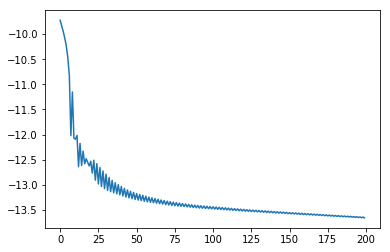

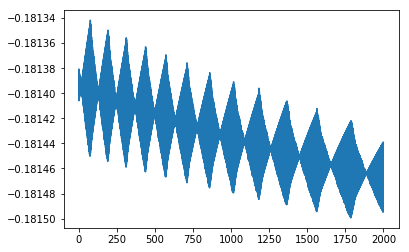

In [19]:
plt.figure()
plt.plot(np.log(loss_hist))
plt.figure()
plt.plot(loss_hist2)

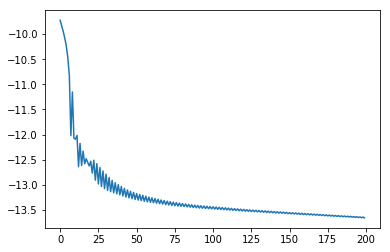

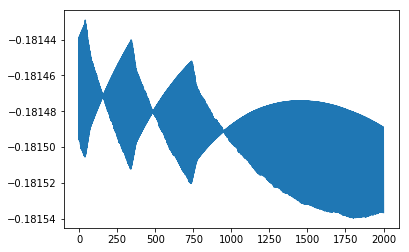

In [24]:
plt.figure()
plt.plot(np.log(loss_hist))
plt.figure()
plt.plot(loss_hist2)

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
preds = []
n_samples = len(x[test_idx])
x_input = Variable(torch.from_numpy(x[test_idx,:].astype(np.float32).reshape(n_samples ,dim))).cuda()
p_input = Variable(torch.from_numpy(p[test_idx].astype(np.float32).reshape(n_samples ,1))).cuda()
output = network.forward(x_input) 
pred = (p_input < output).cpu().data.numpy()
pred = pred[:,0].astype(np.float32)
preds.append(pred)

In [22]:
np.sum(preds)

10136.0

In [17]:
output

Variable containing:
1.00000e-04 *
 3.0757
 3.1032
 3.1045
   ⋮    
 3.0795
 3.0970
 3.1086
[torch.cuda.FloatTensor of size 56435x1 (GPU 0)]

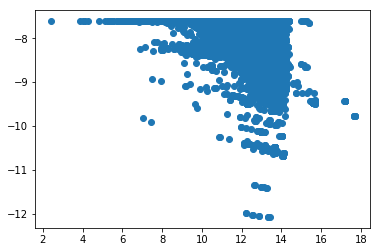

In [176]:
plt.scatter(x[test_idx,0], np.log(output.cpu().data.numpy()))

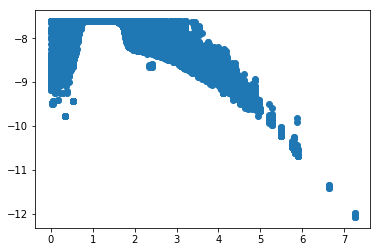

In [177]:
plt.scatter(x[test_idx,1], np.log(output.cpu().data.numpy()))

(0, 0.005)

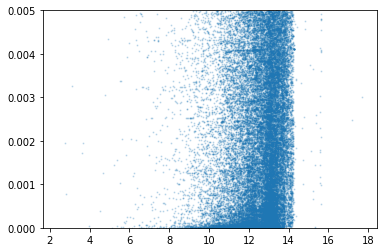

In [178]:
plt.scatter(x[train_idx,0], p[train_idx], 1, alpha = 0.2)
plt.ylim([0, 0.005])

(0, 0.005)

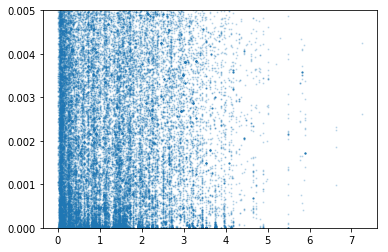

In [135]:
plt.scatter(x[train_idx,1], p[train_idx], 1, alpha = 0.2)
plt.ylim([0, 0.005])

In [26]:
p_target = opt_threshold_multi(x[train_idx,:], p[train_idx], 10, alpha = opt.alpha)